Example notebook to showcase the use of measure_eccentricity().   
Please do not commit your local changes.

NOTE: To work with EOB or NR data, you need to get the data we are working with from `home/md.shaikh/ecc_waveforms` on CIT.


In [1]:
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline

import glob

import sys
sys.path.append("../")

from measureEccentricity.measureEccentricity import get_available_methods
from measureEccentricity import measure_eccentricity
from measureEccentricity.load_data import load_waveform

%load_ext autoreload
%autoreload 2

/home1/md.shaikh/miniconda3/envs/eccimrct/lib/python3.8/site-packages/gwtools/rotations.py:63: UserWarning: Could not import GWFrames, needed for rotations module
  _warnings.warn("Could not import GWFrames, needed for rotations module")
/home1/md.shaikh/miniconda3/envs/eccimrct/lib/python3.8/site-packages/gwtools/__init__.py:11: UserWarning: Could not import rotations, decompositions, or fitfuncs. These are not needed by GWSurrogate.
  _warnings.warn("Could not import rotations, decompositions, or fitfuncs. These are not needed by GWSurrogate.")


### Currently implemented methods

Let's start by seeing which methods are currently implemented

In [2]:
available_methods = list(get_available_methods().keys())
print (available_methods)

['Amplitude', 'Frequency', 'ResidualAmplitude', 'ResidualFrequency']


In the following, we will use these different methods and show what the measured eccentricity looks like. The wrapper function, measure_eccentricity, allows you to easily switch between methods.

In [3]:
# Read the documentation
help(measure_eccentricity)

Help on function measure_eccentricity in module measureEccentricity.measureEccentricity:

measure_eccentricity(tref_in, dataDict, method='Amplitude', return_ecc_method=False, spline_kwargs=None, extra_kwargs=None)
    Measure eccentricity and mean anomaly at reference time.
    
    parameters:
    ----------
    tref_in:
        Input reference time at which to measure eccentricity and mean anomaly.
        Can be a single float or an array. NOTE: eccentricity/mean_ano are
        returned on a different time array tref_out, described below.
    
    dataDict:
        Dictionary containing waveform modes dict, time etc.
        Should follow the format:
            {"t": time, "hlm": modeDict, ...}
            with modeDict = {(l1, m1): h_{l1, m1},
                             (l2, m2): h_{l2, m2}, ...
                            }.
        Some methods may need extra data. For example, the ResidualAmplitude
        method, requires "t_zeroecc" and "hlm_zeroecc" as well in dataDict.
 

### Loading waveform data

Let's now get some waveform data in the required format, using the handy load_waveform function.

Waveform data for measure_eccentricity() are to be provided as a dictionary of different variables. In most cases, the required ones would be the time array and the dictionary of different modes. load_waveform function returns such a dictionary that could be directly used in the measure_eccentricity wrapper function.

In [4]:
help(load_waveform)

Help on function load_waveform in module measureEccentricity.load_data:

load_waveform(catalog='LAL', **kwargs)
    Load waveform from lvcnr file or LAL.
    
    parameters:
    ----------
    catalog:
          Waveform type. could be one of 'LAL', 'LVCNR', EOB
    
    kwargs:
         Kwargs to be passed to the waveform loading functions.



Here is an example of how to load a LAL waveform

In [5]:
# Let's try a PN eccentric model
# We use the keyword "include_zero_ecc" as we want to use the residual amplitude 
# method that needs data for the zero eccentricity counterpart as well
waveform_keywords = {"approximant": "EccentricTD",
                     "q": 1.0,
                     "chi1": [0.0, 0.0, 0.0],
                     "chi2": [0.0, 0.0, 0.0],
                     "deltaTOverM": 0.1,
                     "Momega0": 0.01,
                     "ecc": 0.1,
                     "mean_ano": 0,
                     "phi_ref": 0,
                     "inclination": 0,
                     "include_zero_ecc": True}
dataDictPN = load_waveform(catalog="LAL", **waveform_keywords)

We can use the data and see how the amplitude looks

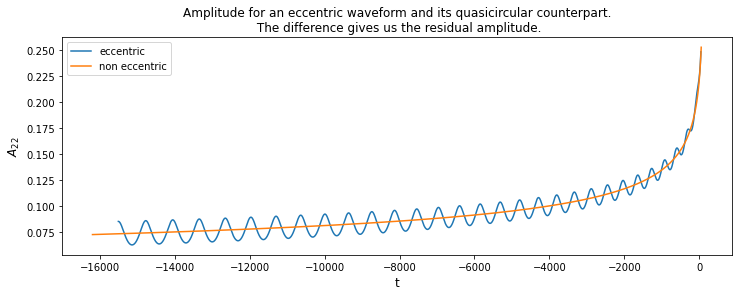

In [6]:
plt.figure(0, figsize=(12, 4))
plt.plot(dataDictPN["t"], np.abs(dataDictPN["hlm"][(2, 2)]), label="eccentric")
plt.plot(dataDictPN["t_zeroecc"], np.abs(dataDictPN["hlm_zeroecc"][(2, 2)]), label="non eccentric")
plt.xlabel('t', fontsize=12)
plt.ylabel('$A_{22}$', fontsize=12)
plt.title('Amplitude for an eccentric waveform and its quasicircular counterpart.\n '
          'The difference gives us the residual amplitude.')
plt.legend();

### Measure eccentricity at a given tref

Now that we have our dataDict ready, let's see how to use it in the measure_eccentricity wrapper function. Below we show how to get the eccentricity and mean anomaly at a given reference time.

In [7]:
# Use measure_eccentricity with your favorite method to 
# compute ecc and mean_ano at a given tref.
# The reason for having a separate tref_out is explained
# in the documentation, as well as below.
tref = -12000
tref_out, ecc, mean_ano = measure_eccentricity(tref, dataDictPN, method="Amplitude")
print (f"ecc={ecc:.3f} and mean_ano={mean_ano:.3f} at tref={tref_out}")

ecc=0.104 and mean_ano=5.951 at tref=-12000


We can try all the methods that are currently implemented

In [8]:
tref = -12000
for method in get_available_methods():
    tref_out, ecc, mean_ano = measure_eccentricity(tref, dataDictPN, method="Amplitude")
    print (f"method={method}: ecc={ecc:.3f} and mean_ano={mean_ano:.3f} at tref={tref_out}")

method=Amplitude: ecc=0.104 and mean_ano=5.951 at tref=-12000
method=Frequency: ecc=0.104 and mean_ano=5.951 at tref=-12000
method=ResidualAmplitude: ecc=0.104 and mean_ano=5.951 at tref=-12000
method=ResidualFrequency: ecc=0.104 and mean_ano=5.951 at tref=-12000


### Diagnostic plots for Amplitude method

In [9]:
tref_vec = dataDictPN["t"][dataDictPN["t"] < -300]
tref_vec = tref_vec[tref_vec > -14000]
tref_out, ecc_vec, mean_ano_vec, eccMethod = measure_eccentricity(tref_vec, dataDictPN, method="Amplitude", 
                                                                      return_ecc_method=True,
                                                                      extra_kwargs={"debug": False})

(<Figure size 432x288 with 1 Axes>,
 <AxesSubplot:xlabel='time', ylabel='$\\Delta\\omega_{22}$'>)

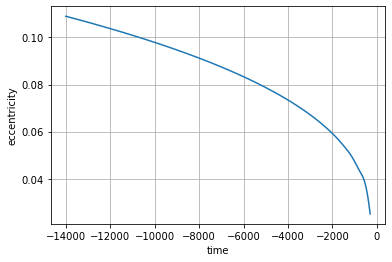

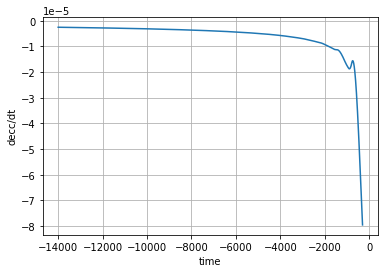

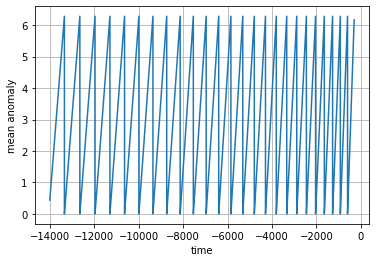

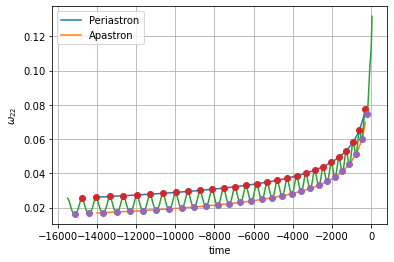

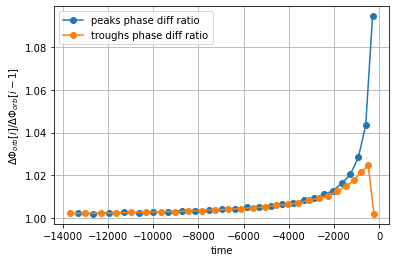

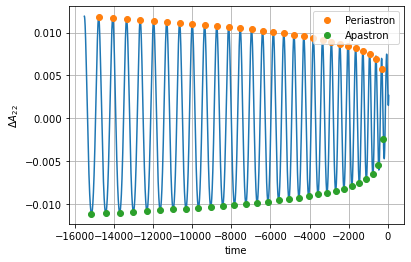

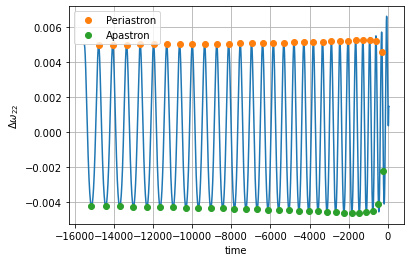

In [10]:
eccMethod.plot_measured_ecc()
eccMethod.plot_decc_dt()
eccMethod.plot_mean_ano()
eccMethod.plot_extrema_in_omega()
eccMethod.plot_phase_diff_ratio_between_peaks()
# if zeroecc data is provided then following diagnostic plots are also available
eccMethod.plot_residual_amp()
eccMethod.plot_residual_omega()

we can club these together as we wish in fig by providing an axis to plot

<AxesSubplot:xlabel='time', ylabel='$\\Delta\\omega_{22}$'>

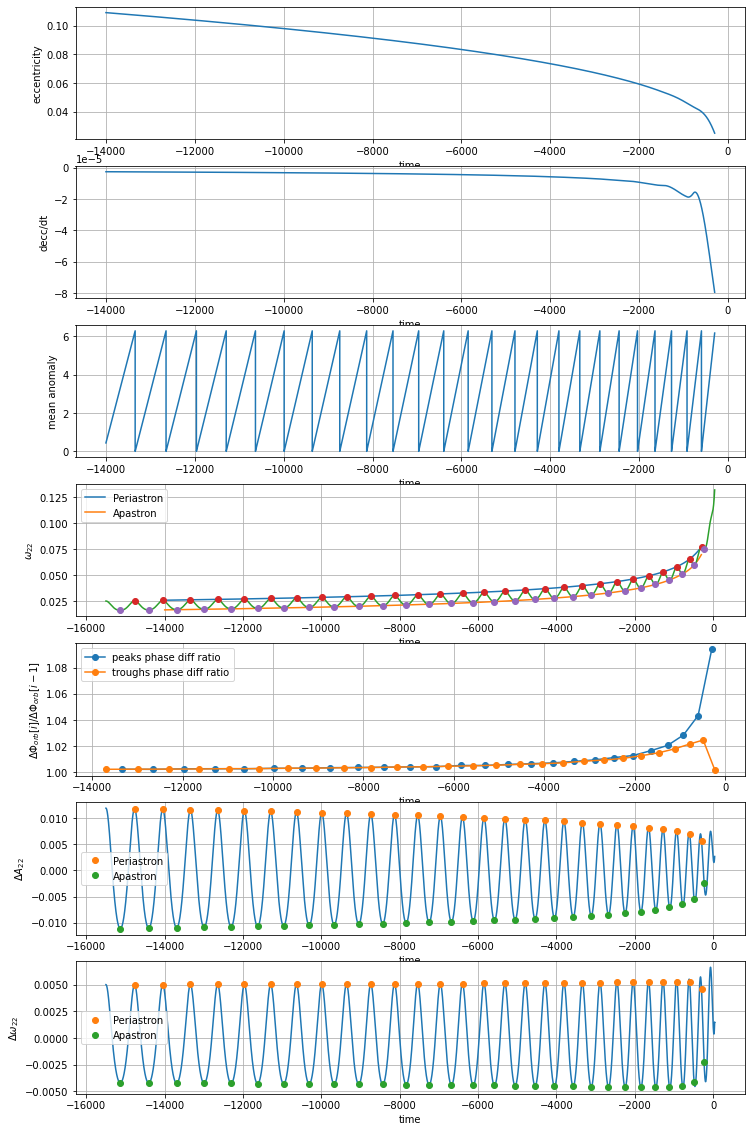

In [11]:
fig, ax = plt.subplots(nrows=7, figsize=(12, 20))
eccMethod.plot_measured_ecc(fig=fig, ax=ax[0])
eccMethod.plot_decc_dt(fig=fig, ax=ax[1])
eccMethod.plot_mean_ano(fig=fig, ax=ax[2])
eccMethod.plot_extrema_in_omega(fig=fig, ax=ax[3])
eccMethod.plot_phase_diff_ratio_between_peaks(fig=fig, ax=ax[4])
eccMethod.plot_residual_amp(fig=fig, ax=ax[5])
eccMethod.plot_residual_omega(fig=fig, ax=ax[6])

Or one can just use the in built make_diagnostic_plots to get all of these at once

(<Figure size 864x2016 with 7 Axes>,
 array([<AxesSubplot:xlabel='time', ylabel='eccentricity'>,
        <AxesSubplot:xlabel='time', ylabel='decc/dt'>,
        <AxesSubplot:xlabel='time', ylabel='mean anomaly'>,
        <AxesSubplot:xlabel='time', ylabel='$\\omega_{22}$'>,
        <AxesSubplot:xlabel='time', ylabel='$\\Delta \\Phi_{orb}[i] / \\Delta \\Phi_{orb}[i-1]$'>,
        <AxesSubplot:xlabel='time', ylabel='$\\Delta\\omega_{22}$'>,
        <AxesSubplot:xlabel='time', ylabel='$\\Delta A_{22}$'>],
       dtype=object))

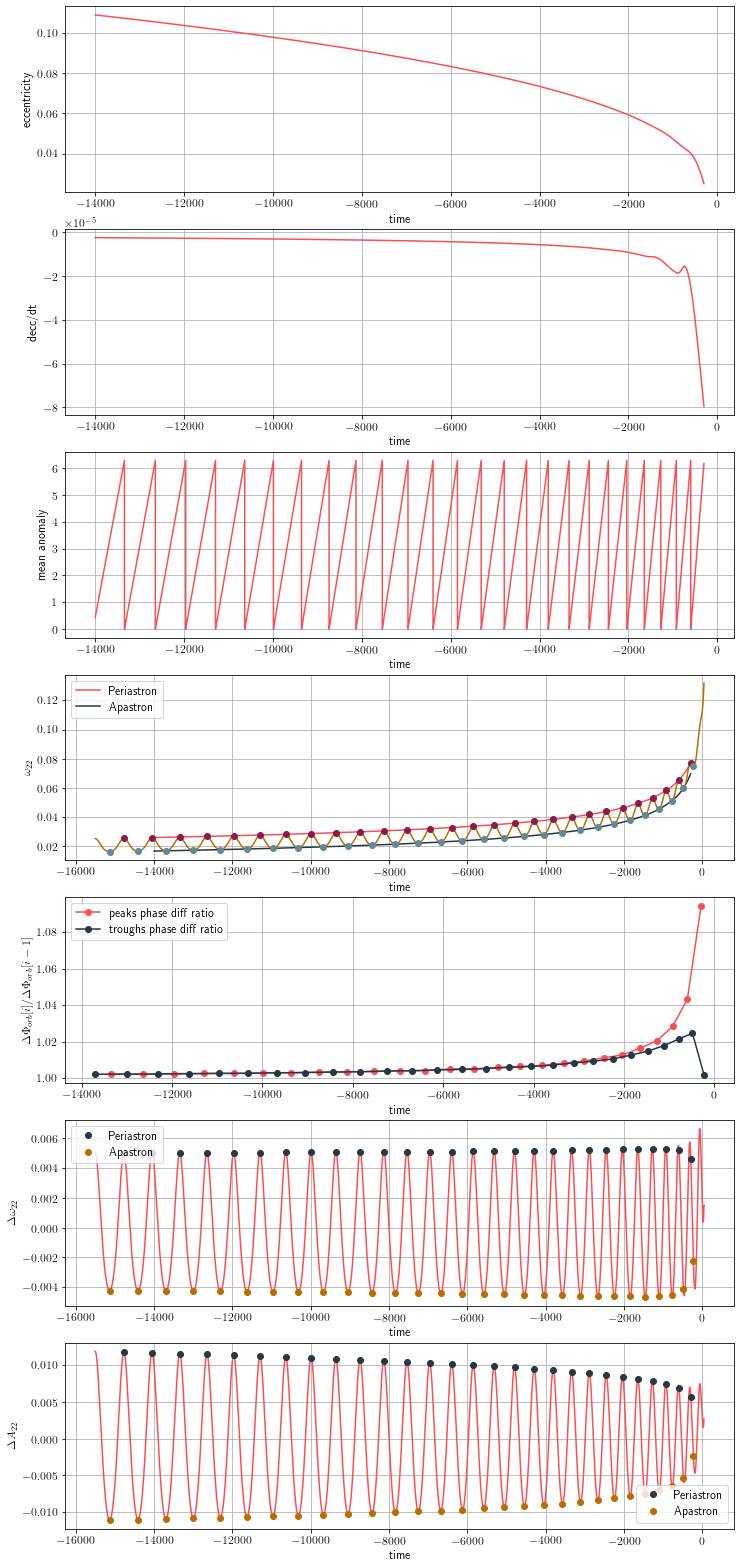

In [13]:
eccMethod.make_diagnostic_plots()

### Lets try for ResidulAmplitude method

In [20]:
tref_vec = dataDictPN["t"][dataDictPN["t"] < -350]
tref_vec = tref_vec[tref_vec > -14000]
tref_out, ecc_vec, mean_ano_vec, eccMethod = measure_eccentricity(tref_vec, dataDictPN, method="ResidualAmplitude", 
                                                                      return_ecc_method=True,
                                                                      extra_kwargs={"debug": False})

(<Figure size 864x2016 with 7 Axes>,
 array([<AxesSubplot:xlabel='time', ylabel='eccentricity'>,
        <AxesSubplot:xlabel='time', ylabel='decc/dt'>,
        <AxesSubplot:xlabel='time', ylabel='mean anomaly'>,
        <AxesSubplot:xlabel='time', ylabel='$\\omega_{22}$'>,
        <AxesSubplot:xlabel='time', ylabel='$\\Delta \\Phi_{orb}[i] / \\Delta \\Phi_{orb}[i-1]$'>,
        <AxesSubplot:xlabel='time', ylabel='$\\Delta\\omega_{22}$'>,
        <AxesSubplot:xlabel='time', ylabel='$\\Delta A_{22}$'>],
       dtype=object))

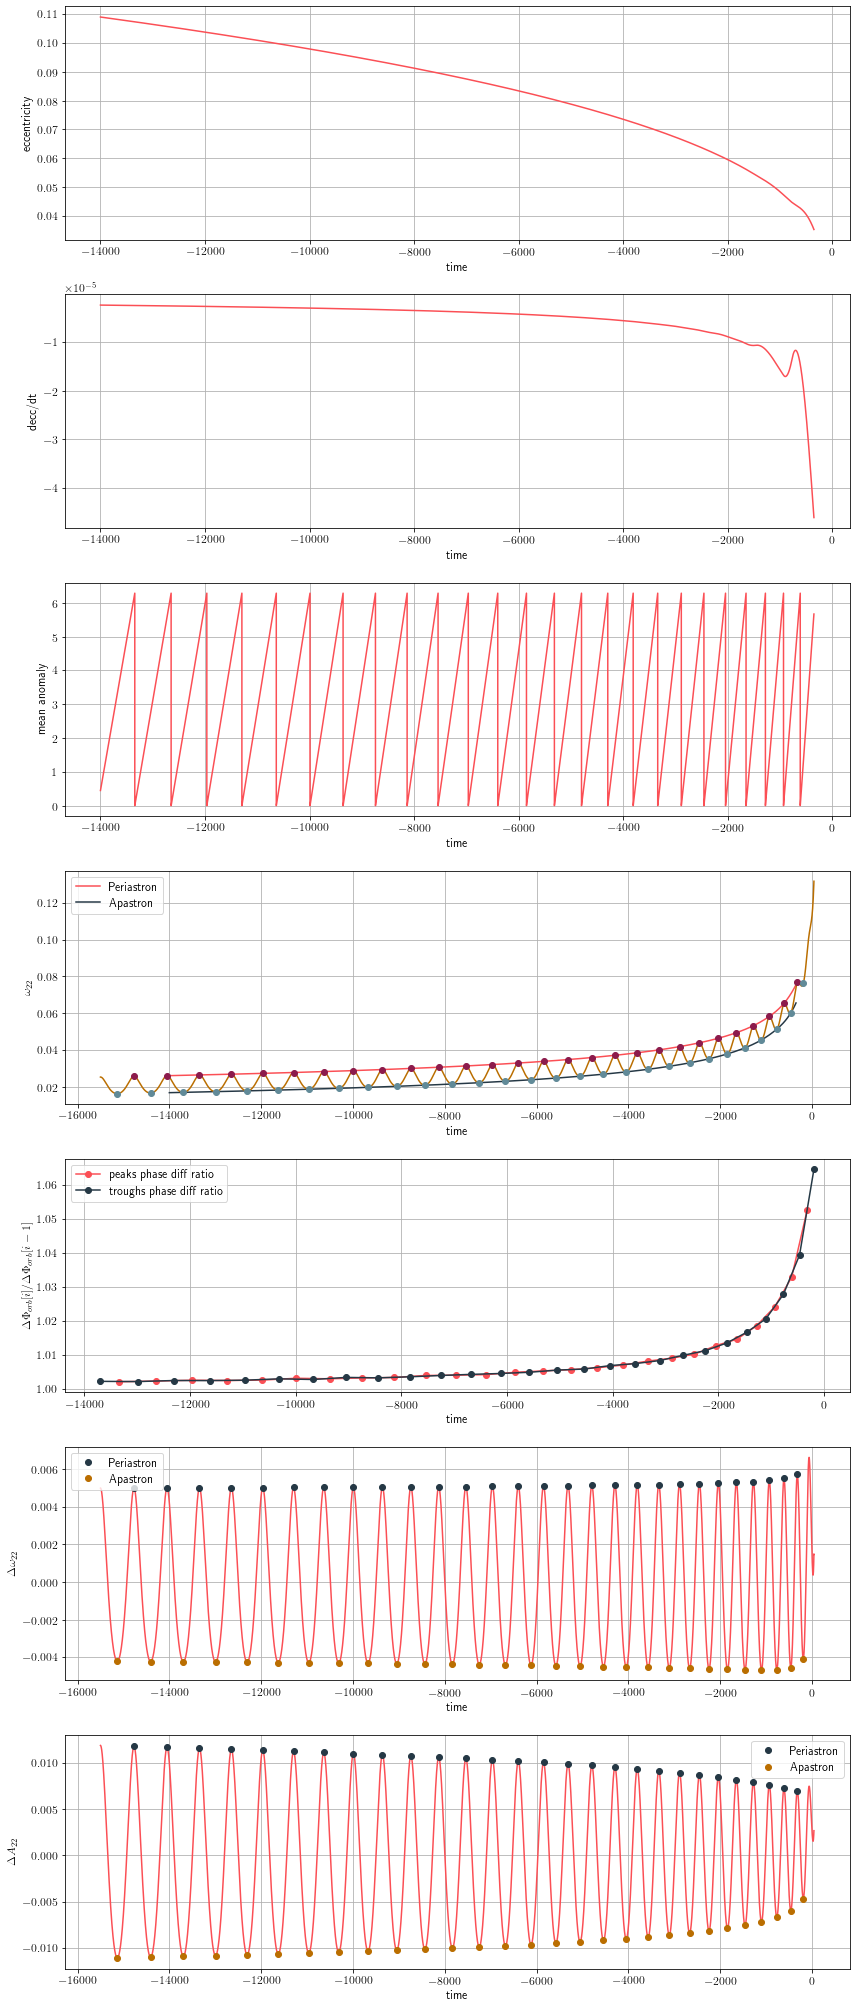

In [21]:
eccMethod.make_diagnostic_plots()

### Changing the figure attributes

We can change the figure attributes by simply providing the arguments to plt.subplots function as a **kwargs

In [24]:
kwargs = {
    "figsize": (6, 21),
    "sharex": True}

(<Figure size 432x1512 with 7 Axes>,
 array([<AxesSubplot:xlabel='time', ylabel='eccentricity'>,
        <AxesSubplot:xlabel='time', ylabel='decc/dt'>,
        <AxesSubplot:xlabel='time', ylabel='mean anomaly'>,
        <AxesSubplot:xlabel='time', ylabel='$\\omega_{22}$'>,
        <AxesSubplot:xlabel='time', ylabel='$\\Delta \\Phi_{orb}[i] / \\Delta \\Phi_{orb}[i-1]$'>,
        <AxesSubplot:xlabel='time', ylabel='$\\Delta\\omega_{22}$'>,
        <AxesSubplot:xlabel='time', ylabel='$\\Delta A_{22}$'>],
       dtype=object))

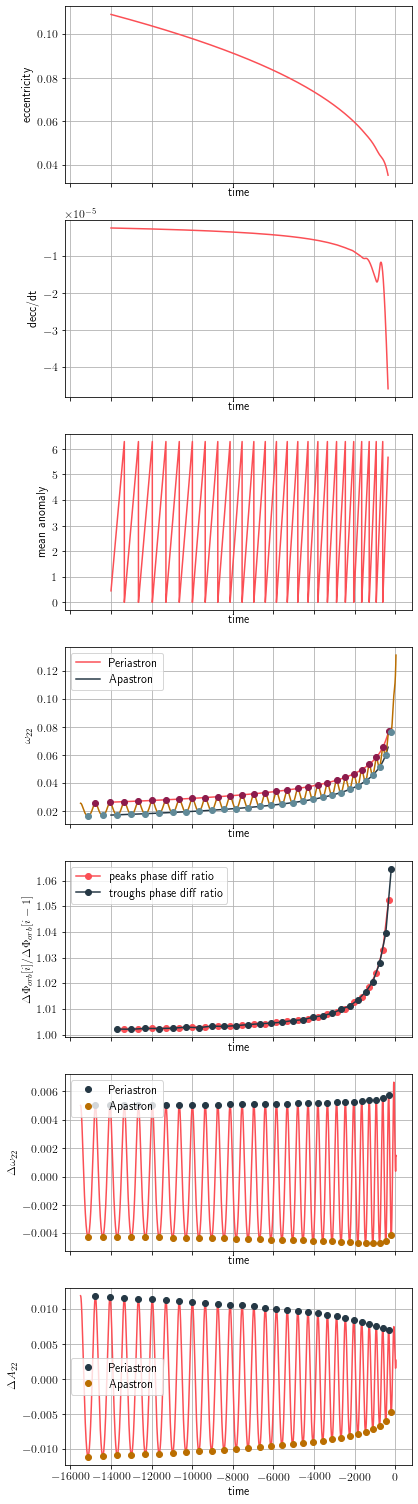

In [25]:
eccMethod.make_diagnostic_plots(**kwargs)

### Diagnostics for EOB waveforms

In [26]:
import os
data_dir = os.path.expanduser("~") + "/ecc_waveforms"
data_dir

'/home1/md.shaikh/ecc_waveforms'

In [38]:
# Pick an EOB waveform from among the available ones, and load it
EOB_file = f'/home1/md.shaikh/ecc_waveforms/Non-Precessing/EOB/EccTest_q1.00_chi1z0.00_chi2z0.00_EOBecc0.0006156252_Momega00.010.h5'
EOB_file_zero_ecc = f'{data_dir}/Non-Precessing/EOB/EccTest_q1.00_chi1z0.00_chi2z0.00_EOBecc0.0000000000_Momega00.002.h5'

eob_kwargs = {"filepath": EOB_file,
              "filepath_zero_ecc": EOB_file_zero_ecc,
              "include_zero_ecc": True} 
dataDictEOB = load_waveform("EOB", **eob_kwargs)

In [39]:
tref_out, ecc_vec, mean_ano_vec, eccMethod = measure_eccentricity(
    tref_vec, dataDictEOB, method=method, 
    return_ecc_method=True)

/home1/md.shaikh/Eccentricity/notebook/../measureEccentricity/eccDefinition.py:353: UserWarning: Ecc(t) is non monotonic.
  warnings.warn("Ecc(t) is non monotonic.")


(<Figure size 864x2016 with 7 Axes>,
 array([<AxesSubplot:xlabel='time', ylabel='eccentricity'>,
        <AxesSubplot:xlabel='time', ylabel='decc/dt'>,
        <AxesSubplot:xlabel='time', ylabel='mean anomaly'>,
        <AxesSubplot:xlabel='time', ylabel='$\\omega_{22}$'>,
        <AxesSubplot:xlabel='time', ylabel='$\\Delta \\Phi_{orb}[i] / \\Delta \\Phi_{orb}[i-1]$'>,
        <AxesSubplot:xlabel='time', ylabel='$\\Delta\\omega_{22}$'>,
        <AxesSubplot:xlabel='time', ylabel='$\\Delta A_{22}$'>],
       dtype=object))

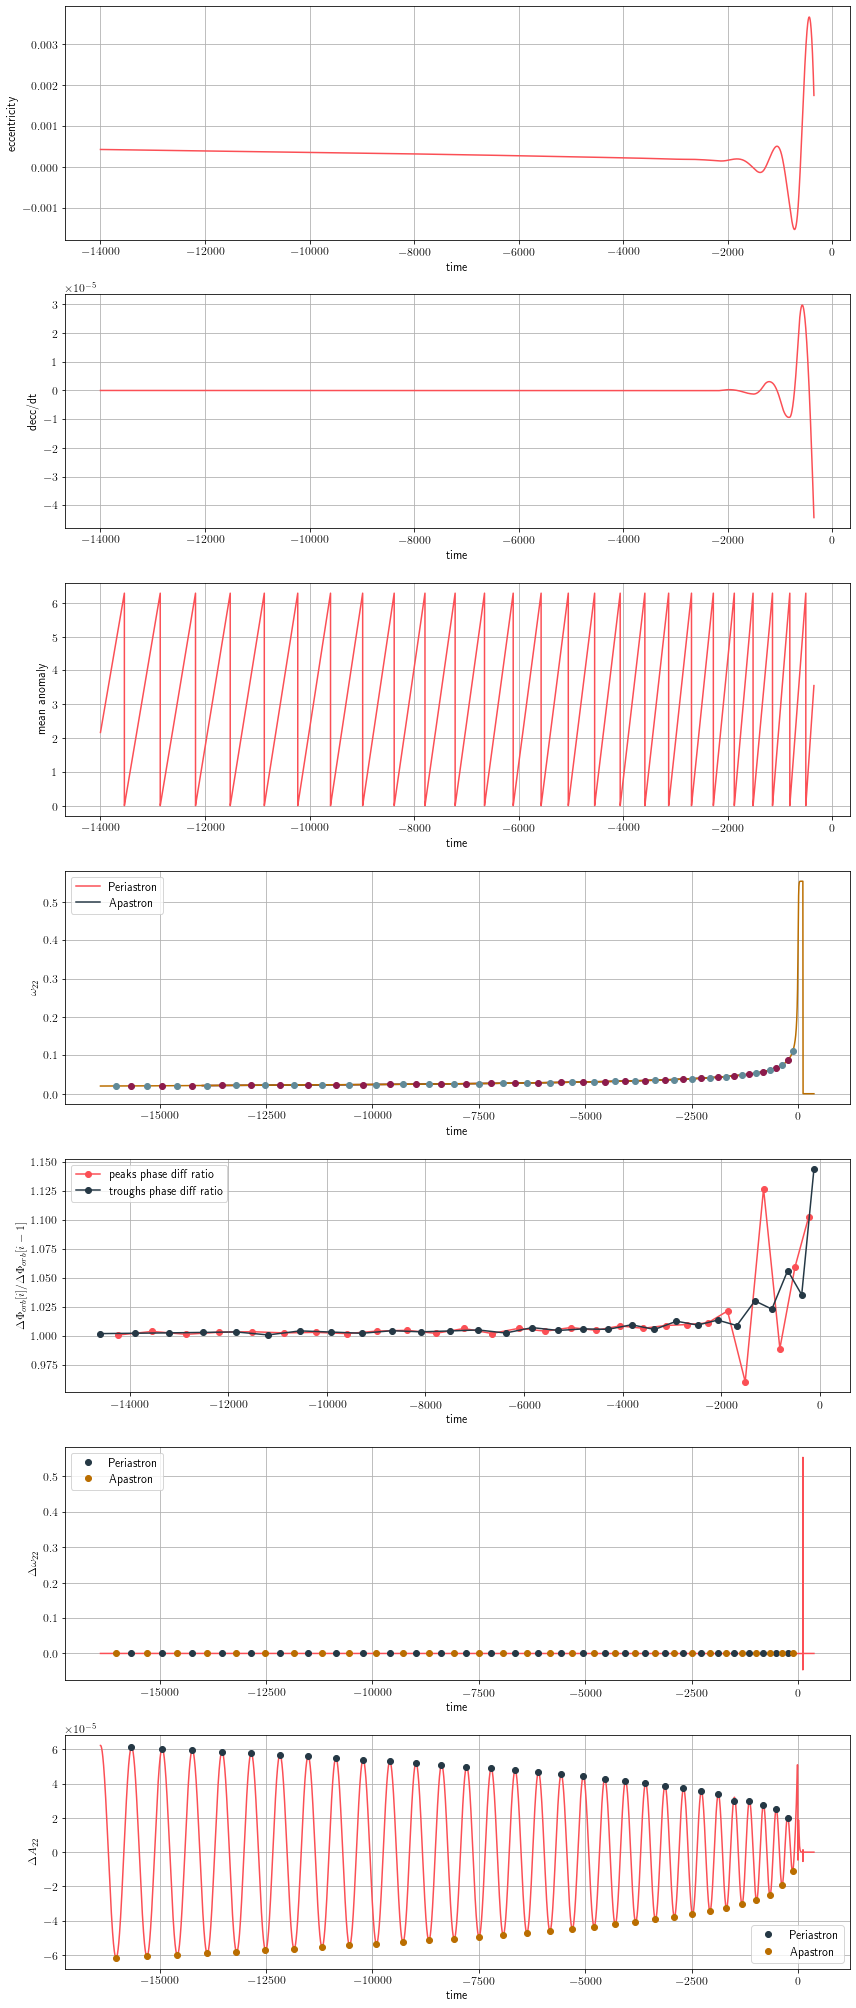

In [40]:
eccMethod.make_diagnostic_plots()

#### Let's make it better

We see non monotonicity near the merger. To understand it why it's happenning, let's zoom in the residual omega to see if the omega22 data itself has some glitch. We focus on the ecc vs time and the residual omega and residual amp plot for this

(-1e-05, 1e-05)

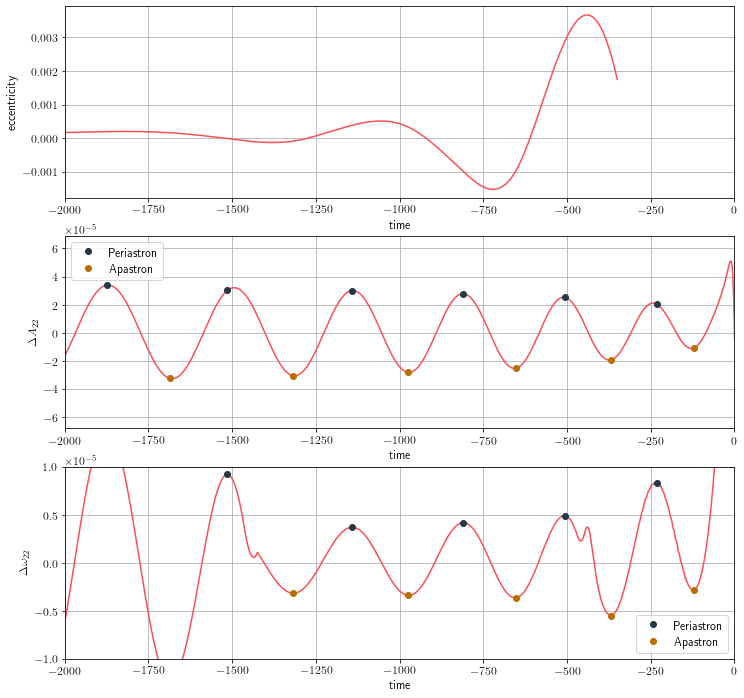

In [44]:
fig, ax = plt.subplots(nrows=3, figsize=(12, 12))
eccMethod.plot_measured_ecc(fig, ax[0])
eccMethod.plot_residual_amp(fig, ax[1])
eccMethod.plot_residual_omega(fig, ax[2])
ax[0].set_xlim(-2000,0)
ax[1].set_xlim(-2000,0)
ax[2].set_xlim(-2000,0)
ax[2].set_ylim(-1e-5, 1e-5)

As we can see there is something wrong happening around this region in the omega data